# Réseau de neurones pour le calcul de flux pour l'advection en 2D

Importer les bibliothèques utiles 

In [106]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sqlite3
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sys
import datetime, os
from sklearn import metrics
from sklearn import preprocessing
from sklearn.utils import shuffle
from time import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm

from sklearn.preprocessing import StandardScaler



from sklearn.model_selection import GridSearchCV

Importer la base de donnée et visualiser les dernieres lignes

In [107]:
con=sqlite3.connect('Table.db')
raw_data=pd.read_sql_query("SELECT * FROM A",con)
data = raw_data.copy()
print(data.tail())
print(type(data))

                   P1            P2            P3            P4            P5  \
3991999  1.044813e-24  1.365423e-24  1.783170e-24  1.044813e-24  1.580897e-24   
3992000  1.073063e-24  9.264329e-25  7.989262e-25  1.401159e-24  1.210625e-24   
3992001  1.828304e-24  1.401159e-24  1.073063e-24  1.580897e-24  1.210625e-24   
3992002  1.365423e-24  1.580897e-24  1.828304e-24  1.044813e-24  1.210625e-24   
3992003  7.989262e-25  1.044813e-24  1.365423e-24  7.989262e-25  1.210625e-24   

                   P6            P7            P8            P9            F1  \
3991999  2.384010e-24  1.401159e-24  1.401159e-24  2.384010e-24  1.127537e-27   
3992000  1.044813e-24  1.828304e-24  1.580897e-24  1.365423e-24  5.199348e-28   
3992001  7.989262e-25  1.365423e-24  1.044813e-24  7.989262e-25  1.000165e-27   
3992002  1.073063e-24  7.989262e-25  7.989262e-25  1.073063e-24  6.791624e-28   
3992003  1.828304e-24  1.073063e-24  1.073063e-24  1.828304e-24  8.637148e-28   

         ...            F3

# Introduction de la stabilité

In [108]:
small_data=data.sample(frac=0.0025,random_state=0) #extraire 
small_data=shuffle(small_data) #shuffle
print(small_data.tail())
print(small_data.shape)
print(type(small_data))



                   P1            P2            P3            P4            P5  \
1746580  7.761116e-01  7.815926e-01  7.870343e-01  7.771249e-01  7.825992e-01   
1816594  1.282018e-04  1.238558e-04  1.196463e-04  1.219369e-04  1.177948e-04   
1102418  2.455255e-19  2.279895e-19  2.116765e-19  2.160220e-19  2.005783e-19   
1994677  9.456897e-01  9.444849e-01  9.432609e-01  9.487514e-01  9.475773e-01   
1440452  9.887123e-04  1.022783e-03  1.057927e-03  1.023750e-03  1.058951e-03   

                   P6            P7            P8            P9            F1  \
1746580  7.880340e-01  7.781248e-01  7.835925e-01  7.890204e-01  6.365781e-04   
1816594  1.081855e-04  1.159547e-04  1.159547e-04  1.081855e-04  9.738891e-08   
1102418  1.637715e-19  1.900166e-19  1.900166e-19  1.637715e-19  1.843371e-22   
1994677  9.494260e-01  9.517311e-01  9.505881e-01  9.494260e-01  1.433101e-04   
1440452  1.095259e-03  1.059871e-03  1.096234e-03  1.133739e-03  8.739312e-07   

         ...            F3

<class 'pandas.core.series.Series'>


Text(0, 0.5, 'Fonction objectif')

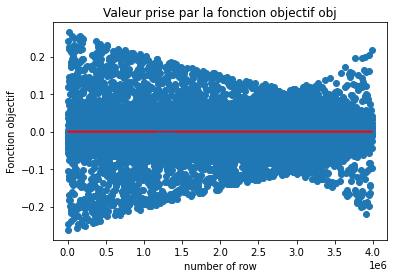

In [109]:
#Attention, on devra faire varier dt et dx (=dy)
dx=1/1001 #?
dy=1/1001 #?
dt=0.01 #?

#Calcul fonction objectif
w = small_data['P5']
print(type(w))
obj = ((small_data['F1']-small_data['F4'])/(dx*w))+((small_data['F3']-small_data['F2'])/(dy*w))

#A retenir: j'utilise le fait que la serie 'obj' suit le meme ordre d'indentation que small_data, est-ce vrai?

absi = small_data.index
plt.scatter(absi,obj)
nul = [0 for i in range((small_data.shape)[0])]
plt.plot(absi,nul,'r')
plt.title('Valeur prise par la fonction objectif obj')
plt.xlabel('number of row')
plt.ylabel('Fonction objectif')

Text(0, 0.5, 'Fonction objectif')

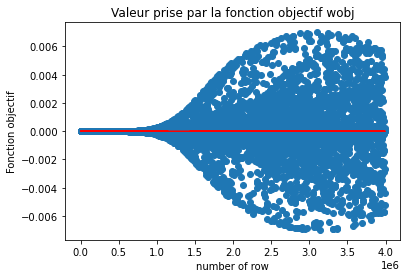

In [110]:
###Insertion de wobj
dx=1/1001 #?
dy=1/1001 #?
dt=0.01 #?

w = small_data['P5']
wobj = ((small_data['F1']-small_data['F4'])/(dx))+((small_data['F3']-small_data['F2'])/(dy))


absi = small_data.index
plt.scatter(absi,wobj)
nul = [0 for i in range((small_data.shape)[0])]
plt.plot(absi,nul,'r')
plt.title('Valeur prise par la fonction objectif wobj')
plt.xlabel('number of row')
plt.ylabel('Fonction objectif')

Text(0, 0.5, 'Fonction objectif')

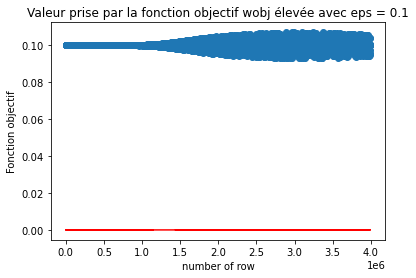

In [196]:
#"Elevation" des données stabilité

weps = 0.1
obj_prime = wobj+weps

small_data['obj_prime']=obj_prime

absi = small_data.index
plt.scatter(absi,obj_prime)
nul = [0 for i in range((small_data.shape)[0])]
plt.plot(absi,nul,'r')
plt.title('Valeur prise par la fonction objectif wobj élevée avec eps = '+str(weps))
plt.xlabel('number of row')
plt.ylabel('Fonction objectif')


# Scaler les données

but : moyenne = 0 et Ecart type = 1 >> recours a la fonction : preprocessing.StandardScaler()



moyenne: [ 1.60396547e-01  1.60416232e-01  1.60436281e-01  1.60406544e-01
  1.60371121e-01  1.60297751e-01  1.60306837e-01  1.60285684e-01
  1.60345583e-01  7.72808417e-05  7.80860777e-05  7.81018498e-05
  7.72662893e-05 -5.67106104e-03  6.29223618e-03 -7.46448427e-03
  8.91523874e-03 -7.27952707e-03  8.26281048e-03 -6.31795292e-03
  6.09525853e-03  1.00030355e-01]
std [8.68567895e-02 8.68693803e-02 8.68823698e-02 8.68393253e-02
 8.68225164e-02 8.67801806e-02 8.67638511e-02 8.67600126e-02
 8.67886545e-02 2.71774223e-08 2.74562837e-08 2.74683068e-08
 2.71699468e-08 5.02437863e-01 4.97490384e-01 5.02311599e-01
 4.97553201e-01 5.02325330e-01 4.97553405e-01 5.02432055e-01
 4.97490876e-01 2.23040065e-06]


StandardScaler()

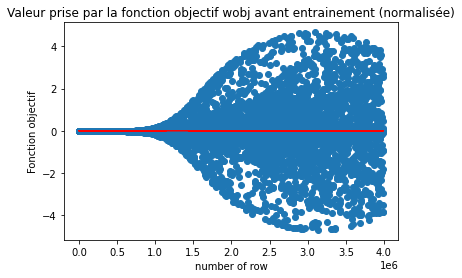

In [197]:
#On normalise avec scaler classique sur tout
x=small_data.values
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
data_scaled = pd.DataFrame(x_scaled)
col = ['P1','P2','P3','P4','P5','P6','P7','P8','P9','F1','F2','F3','F4','A1','B1','A2','B2','A3','B3','A4','B4','obj_prime']
data_scaled.columns = ['P1','P2','P3','P4','P5','P6','P7','P8','P9','F1','F2','F3','F4','A1','B1','A2','B2','A3','B3','A4','B4','obj_prime']

print('moyenne:',scaler.mean_)
print('std',scaler.var_)

absi = small_data.index
plt.scatter(absi,data_scaled['obj_prime'])
nul = [0 for i in range((small_data.shape)[0])]
plt.plot(absi,nul,'r')
plt.title('Valeur prise par la fonction objectif wobj avant entrainement (normalisée)')
plt.xlabel('number of row')
plt.ylabel('Fonction objectif')

###Introduction inverse transform pour les flux
output_unscaled = small_data[['F1','F2','F3','F4','obj_prime']]
output_unscaled_values = output_unscaled.values
output_scaler = preprocessing.StandardScaler()
output_scaled_values = output_scaler.fit_transform(output_unscaled_values)

###Introduction inverse transform pour les valeurs d'entree du réseau
input_unscaled = small_data[['P1','P2','P3','P4','P5','P6','P7','P8','P9','A1','B1','A2','B2','A3','B3','A4','B4']]
input_unscaled_values = input_unscaled.values
input_scaler = preprocessing.StandardScaler()
input_scaler.fit(input_unscaled_values)

# Extraire une 'petite' base de donnée de table.db, taille de l'ordre de 10 000

In [198]:
#data_scaled_extraite=data_scaled.sample(frac=0.0025,random_state=0) #extraire 
#data_scaled_extraite=shuffle(data_scaled_extraite) #shuffle

data_scaled_extraite=data_scaled
Data_copy=data_scaled_extraite.copy()
data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9980 entries, 0 to 9979
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   P1         9980 non-null   float64
 1   P2         9980 non-null   float64
 2   P3         9980 non-null   float64
 3   P4         9980 non-null   float64
 4   P5         9980 non-null   float64
 5   P6         9980 non-null   float64
 6   P7         9980 non-null   float64
 7   P8         9980 non-null   float64
 8   P9         9980 non-null   float64
 9   F1         9980 non-null   float64
 10  F2         9980 non-null   float64
 11  F3         9980 non-null   float64
 12  F4         9980 non-null   float64
 13  A1         9980 non-null   float64
 14  B1         9980 non-null   float64
 15  A2         9980 non-null   float64
 16  B2         9980 non-null   float64
 17  A3         9980 non-null   float64
 18  B3         9980 non-null   float64
 19  A4         9980 non-null   float64
 20  B4      

## Diviser la base de donnée 0.7 > entrainement ET 0.3 > test

In [199]:
print('The shape of the initial data before spliting it'+str(data_scaled_extraite.shape))


data_training=data_scaled_extraite.sample(frac=0.7,random_state=0) 
data_test=data_scaled_extraite.drop(data_training.index)

print('The shape of the initial data for training'+str(data_training.shape))
print('The shape of the initial data for testing'+str(data_test.shape))


data_training_labels = pd.DataFrame(columns =['F1','F2','F3','F4','obj_prime'])
data_test_labels = pd.DataFrame(columns =['F1','F2','F3','F4','obj_prime'])

data_training_labels['F1']=data_training['F1']
data_training_labels['F2']=data_training['F2']
data_training_labels['F3']=data_training['F3']
data_training_labels['F4']=data_training['F4']
#necessaire pour l'entrainement? On doit juste vérifier si la sortie est stable
data_training_labels['obj_prime']=data_training['obj_prime']


data_test_labels['F1']=data_test['F1']
data_test_labels['F2']=data_test['F2']
data_test_labels['F3']=data_test['F3']
data_test_labels['F4']=data_test['F4']
#Ici c'est nécessaire par contre
data_test_labels['obj_prime']=data_test['obj_prime']


data_training.pop('F1')
data_training.pop('F2')
data_training.pop('F3')
data_training.pop('F4')
data_training.pop('obj_prime')

data_test.pop('F1')
data_test.pop('F2')
data_test.pop('F3')
data_test.pop('F4')
data_test.pop('obj_prime')

data_training_features=data_training
data_test_features=data_test

print('The shape of the features dataframe for training'+str(data_training_features.shape))
print('The shape of the features dataframe for testing'+str(data_test_features.shape))
print('The shape of the labels dataframe for training'+str(data_training_labels.shape))
print('The shape of the labels dataframe for testing'+str(data_test_labels.shape))





data_training_labels.info()





The shape of the initial data before spliting it(9980, 22)
The shape of the initial data for training(6986, 22)
The shape of the initial data for testing(2994, 22)
The shape of the features dataframe for training(6986, 17)
The shape of the features dataframe for testing(2994, 17)
The shape of the labels dataframe for training(6986, 5)
The shape of the labels dataframe for testing(2994, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6986 entries, 6907 to 5047
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   F1         6986 non-null   float64
 1   F2         6986 non-null   float64
 2   F3         6986 non-null   float64
 3   F4         6986 non-null   float64
 4   obj_prime  6986 non-null   float64
dtypes: float64(5)
memory usage: 327.5 KB


## Créer le modèle de réseau de neurones ( fonction d'activation = LeakyRelu ) 

Définir shape = nombre de 'features' d'entrée

In [200]:
shape = len(data.columns)-4
print(shape)

17


On crée le réseau de neuronnes avec une implémentation du Dropout, BUT : Regularisation et diminuer l'effet du overfitting (Dropout > randomly reducing the number of interconnecting neurons within a neural network), on choisit le dropout_rate=0.2, et on l'applique sur toute les Hidden layers.




In [201]:
def build_model():
    model = keras.Sequential()
    model.add(layers.Dense(17,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(20,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(30,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(20,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(5,use_bias=True,activation='elu'))

    return model

model = build_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 17)                306       
_________________________________________________________________
dropout_36 (Dropout)         (None, 17)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 20)                360       
_________________________________________________________________
dropout_37 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 30)                630       
_________________________________________________________________
dropout_38 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 20)               

Nombre de degré de liberté du réseau : 6 051 , du meme ordre de la taille de la base de données => Overfitting/Underfitting évité

Optimiser le réseau, on choisit l'algorithm Adam et 20 000 epoches ( on peut changer d'algorithm d'optimisation apres ( gradient descent par exemple ), ca dependra de la performance ) 
On a pas encore Etudié le batch_size, on met une valeur arbitraire de 128

In [202]:
def train_model():
  
    
  optimizer = tf.optimizers.Adam() #Algorithm d'optimisation

  model.compile(loss='mse',
                optimizer='adam',
                metrics=['mse'])

  early_stop = keras.callbacks.EarlyStopping(monitor='val_mse',min_delta=1e-17, patience=10)
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1,profile_batch=0)


  model.fit(data_training_features, 
            data_training_labels, 
            epochs=600,
            batch_size=120,
            validation_split = 0.5, 
            verbose=0, 
            callbacks=[early_stop,tensorboard_callback])

La méthode callbacks.TensorBoard() a été ajouté pour conserver la performence du Réseau de neurones a chaque itération (epochs) et visualiser les courbes a la fin

# Save the model in .h5 format 

In [203]:
train_model()
model.save("Advection2D_elevation_eps2.h5")

# Résultats

In [204]:
Y_pred_scaled=model.predict(data_test_features) #output du réseau, qu'on veut comparer a Y_test
Y_test_scaled=data_test_labels

Y_pred_df=pd.DataFrame(Y_pred_scaled,columns=['F1','F2','F3','F4','obj_prime'])


#dx=1/1001 #? Attention; ils ne sont pas normalisés ceux-là!
#dy=1/1001 #?
#dt=0.01 #?

#Calcul fonction objectif
#w = data_test_features['P5']
#Y_pred=Y_preddd
#w = w.reset_index()
#del w['index']

#print(type(w))
#print(w.index)
#print(Y_pred.index)
#obj_scaled = ((Y_pred['F1']-Y_pred['F4'])/(dx*w['P5']))+((Y_pred['F3']-Y_pred['F2'])/(dy*w['P5']))
#wobj_scaled = ((Y_pred['F1']-Y_pred['F4'])/(dx))+((Y_pred['F3']-Y_pred['F2'])/(dy))
#print(obj_scaled.shape)
#print(wobj_scaled.tail())
#print(type(obj_scaled))
#print(obj_scaled.index)



#absi = obj_scaled.index
#plt.scatter(absi,wobj_scaled)
#plt.scatter(absi,obj_scaled)
#print('moyenne:',wobj_scaled.mean())
#print('ecart-type:',wobj_scaled.std())
#nul = [0 for i in range((obj_scaled.shape)[0])]
#plt.plot(absi,nul,'r')

#x_min = absi[0]
#x_max = absi.shape[0]
#temp = data_test_labels['obj_prime']
#y_max = temp.max()
#y_min = temp.min()

#plt.title('Valeur prise par la fonction objectif wobj_scaled calculé après le reseau (normalisé)')
#plt.xlabel('number of row')
#plt.ylabel('Fonction objectif')
#plt.axis([x_min, x_max, y_min, y_max])


### Ici tout est normalisé
#au_dessus_prevu = Y_pred.loc[Y_pred['obj_prime']>=0]
#nb_au_dessus_prevu = au_dessus_prevu.shape[0]
#print('nb de wobj prévu positif: '+str(nb_au_dessus_prevu))
#en_dessous_prevu = Y_pred[Y_pred['obj_prime']<0]
#nb_en_dessous_prevu = en_dessous_prevu.shape[0]
#print('nb de wobj prévu négatif: '+str(nb_en_dessous_prevu))

#wobj_scaled = wobj_scaled.to_frame()
#wobj_scaled.columns = ['wobj_scaled']
#au_dessus_realise = wobj_scaled.loc[wobj_scaled['wobj_scaled']>=0]
#nb_au_dessus_realise = au_dessus_realise.shape[0]
#print('nb de wobj effectué positif: '+str(nb_au_dessus_realise))
#en_dessous_realise = wobj_scaled.loc[wobj_scaled['wobj_scaled']<0]
#nb_en_dessous_realise = en_dessous_realise.shape[0]
#print('nb de wobj effectué négatif: '+str(nb_en_dessous_realise))

Dénormalisation de Ypred

In [205]:
Y_pred_unscaled = output_scaler.inverse_transform(Y_pred_scaled)
Y_test_unscaled = output_scaler.inverse_transform(Y_test_scaled)

Y_pred_unscaled_df = pd.DataFrame(Y_pred_unscaled,columns=['F1','F2','F3','F4','obj_prime'])
Y_test_unscaled_df = pd.DataFrame(Y_test_unscaled,columns=['F1','F2','F3','F4','obj_prime'])



On affiche et on vérifie wobj, ce qui donne une idée du signe mais pas de l'amplitude

moyenne: 0.00010396917059551924
ecart-type: 0.0009391937055625021
moyenne du scaler[7.72808417e-05 7.80860777e-05 7.81018498e-05 7.72662893e-05
 1.00030355e-01]
variance du scaler[2.71774223e-08 2.74562837e-08 2.74683068e-08 2.71699468e-08
 2.23040065e-06]
nb de wobj_unscaled effectué positif: 1672
nb de wobj_unscaled effectué négatif: 1322


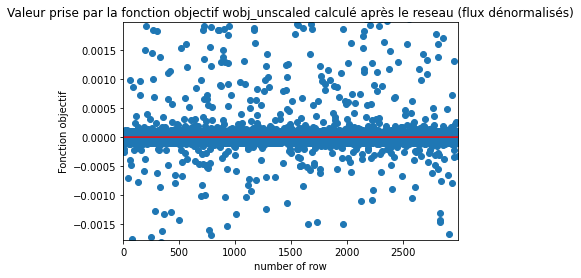

In [206]:
#On va étudier avec wobj en dénormalisé
dx=1/1001 #? Attention; ils ne sont pas normalisés ceux-là!
dy=1/1001 #?
dt=0.01 #?
wobj_unscaled = ((Y_pred_unscaled_df['F1']-Y_pred_unscaled_df['F4'])/(dx))+((Y_pred_unscaled_df['F3']-Y_pred_unscaled_df['F2'])/(dy))

absi = wobj_unscaled.index
plt.scatter(absi,wobj_unscaled)
print('moyenne:',wobj_unscaled.mean())
print('ecart-type:',wobj_unscaled.std())
nul = [0 for i in range((wobj_unscaled.shape)[0])]
plt.plot(absi,nul,'r')


x_min = absi[0]
x_max = absi.shape[0]
y_max = wobj_unscaled.mean() + 2*wobj_unscaled.std()
y_min = wobj_unscaled.mean() - 2*wobj_unscaled.std()
print('moyenne du scaler'+str(output_scaler.mean_))
print('variance du scaler'+str(output_scaler.var_))

plt.title('Valeur prise par la fonction objectif wobj_unscaled calculé après le reseau (flux dénormalisés)')
plt.xlabel('number of row')
plt.ylabel('Fonction objectif')
plt.axis([x_min, x_max, y_min, y_max])


### Ici tout est dénormalisé
wobj_unscaled = wobj_unscaled.to_frame()
wobj_unscaled.columns = ['wobj_unscaled']

au_dessus_realise = wobj_unscaled.loc[wobj_unscaled['wobj_unscaled']>=0]
nb_au_dessus_realise = au_dessus_realise.shape[0]
print('nb de wobj_unscaled effectué positif: '+str(nb_au_dessus_realise))
en_dessous_realise = wobj_unscaled.loc[wobj_unscaled['wobj_unscaled']<0]
nb_en_dessous_realise = en_dessous_realise.shape[0]
print('nb de wobj_unscaled effectué négatif: '+str(nb_en_dessous_realise))



Affichage de la fontion obj avec w et les flux dénormalisés

2989    4.143707e-10
2990    8.030851e-11
2991    6.490023e-04
2992    1.587093e-02
2993    9.475773e-01
Name: P5, dtype: float64
<class 'pandas.core.series.Series'>
moyenne: 2022088808.2579093
ecart-type: 1002644386212.1174
nb de obj_unscaled effectué positif: 1672
nb de obj_unscaled effectué négatif: 1322
ratio d'élimination (négatif/positif): 0.7906698564593302


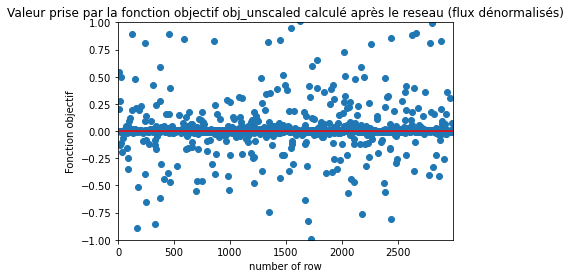

In [207]:
data_test_labels_unscaled = input_scaler.inverse_transform(data_test_features)
data_test_labels_unscaled_df = pd.DataFrame(data_test_labels_unscaled,columns=['P1','P2','P3','P4','P5','P6','P7','P8','P9','A1','B1','A2','B2','A3','B3','A4','B4'])

w = data_test_labels_unscaled_df['P5']
print(w.tail())
print(type(w))
dx = 1/1001
dy = 1/1001
obj_unscaled = ((Y_pred_unscaled_df['F1']-Y_pred_unscaled_df['F4'])/(dx*w))+((Y_pred_unscaled_df['F3']-Y_pred_unscaled_df['F2'])/(dy*w))


#Calcul fonction objectif
#w = data_test_features['P5']
#Y_pred=Y_preddd
#w = w.reset_index()
#del w['index']

absi = obj_unscaled.index
plt.scatter(absi,obj_unscaled)
print('moyenne:',obj_unscaled.mean())
print('ecart-type:',obj_unscaled.std())
nul = [0 for i in range((obj_unscaled.shape)[0])]
plt.plot(absi,nul,'r')


x_min = absi[0]
x_max = absi.shape[0]
y_max = 1
y_min = -1

plt.title('Valeur prise par la fonction objectif obj_unscaled calculé après le reseau (flux dénormalisés)')
plt.xlabel('number of row')
plt.ylabel('Fonction objectif')
plt.axis([x_min, x_max, y_min, y_max])


### Ici tout est dénormalisé
obj_unscaled = obj_unscaled.to_frame()
obj_unscaled.columns = ['obj_unscaled']

au_dessus_realise = obj_unscaled.loc[obj_unscaled['obj_unscaled']>=0]
nb_au_dessus_realise = au_dessus_realise.shape[0]
print('nb de obj_unscaled effectué positif: '+str(nb_au_dessus_realise))
en_dessous_realise = obj_unscaled.loc[obj_unscaled['obj_unscaled']<0]
nb_en_dessous_realise = en_dessous_realise.shape[0]
print('nb de obj_unscaled effectué négatif: '+str(nb_en_dessous_realise))
print("ratio d'élimination (négatif/positif): "+str(nb_en_dessous_realise/nb_au_dessus_realise))


Cette partie la vérifie uniquement que le réseau cherche bien à prédir obj_prime positif

nb de wobj prédit positif: 2994
nb de wobj prédit négatif: 0


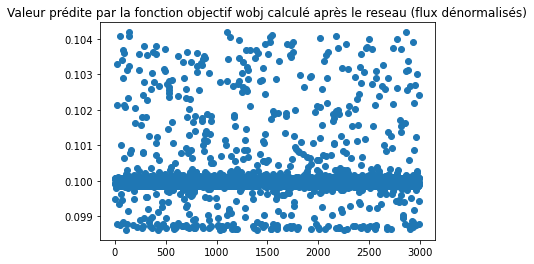

In [208]:

plt.scatter(Y_pred_unscaled_df.index,Y_pred_unscaled_df['obj_prime'])

plt.title('Valeur prédite par la fonction objectif wobj calculé après le reseau (flux dénormalisés)')
au_dessus_realise = Y_pred_unscaled_df.loc[Y_pred_unscaled_df['obj_prime']>=0]
nb_au_dessus_realise = au_dessus_realise.shape[0]
print('nb de wobj prédit positif: '+str(nb_au_dessus_realise))
en_dessous_realise = Y_pred_unscaled_df.loc[Y_pred_unscaled_df['obj_prime']<0]
nb_en_dessous_realise = en_dessous_realise.shape[0]
print('nb de wobj prédit négatif: '+str(nb_en_dessous_realise))


In [188]:
def visualize1(): #we feed it the test data
    plt.scatter(data_test_labels['F1'],Y_pred_df['F1'], color = 'red',marker=".")
    plt.scatter(data_test_labels['F1'],data_test_labels['F1'], color = 'black',marker=".") #just for the y=x black line, the result (red points) should be close to the line
    
    plt.title('Neural Network prediction de F1')
    plt.xlabel('exact')
    plt.ylabel('prediction')
    
    R2=metrics.r2_score(data_test_labels, Y_pred_df)
    
    Correl=np.corrcoef(data_test_labels, Y_pred_df)[0, 1]
    
    print('Model Performance')
    print('Correlation: {:0.4f}.'.format(Correl))
    print('R2: {:0.4f}.'.format(R2))
    
    plt.show() 
    


In [189]:
def visualize2(): #we feed it the test data
    plt.scatter(data_test_labels['F2'],Y_pred_df['F2'], color = 'red',marker=".")
    plt.scatter(data_test_labels['F2'],data_test_labels['F2'], color = 'black',marker=".") #just for the y=x black line, the result (red points) should be close to the line
    
    
    plt.title('Neural Network prediction de F2')
    plt.xlabel('exact')
    plt.ylabel('prediction')
    
    R2=metrics.r2_score(data_test_labels, Y_pred_df)
    
    Correl=np.corrcoef(data_test_labels, Y_pred_df)[0, 1]
    
    print('Model Performance')
    print('Correlation: {:0.4f}.'.format(Correl))
    print('R2: {:0.4f}.'.format(R2))
    
    plt.show()

In [190]:
def visualize3(): #we feed it the test data
    plt.scatter(data_test_labels['F3'],Y_pred_df['F3'], color = 'red',marker=".")
    plt.scatter(data_test_labels['F3'],data_test_labels['F3'], color = 'black',marker=".") #just for the y=x black line, the result (red points) should be close to the line
    
    
    plt.title('Neural Network prediction de F3')
    plt.xlabel('exact')
    plt.ylabel('prediction')
    
    R2=metrics.r2_score(data_test_labels, Y_pred_df)
    
    Correl=np.corrcoef(data_test_labels, Y_pred_df)[0, 1]
    
    print('Model Performance')
    print('Correlation: {:0.4f}.'.format(Correl))
    print('R2: {:0.4f}.'.format(R2))
    
    plt.show()

In [191]:
def visualize4(): #we feed it the test data
    plt.scatter(data_test_labels['F4'],Y_pred_df['F4'], color = 'red',marker=".")
    plt.scatter(data_test_labels['F4'],data_test_labels['F4'], color = 'black',marker=".") #just for the y=x black line, the result (red points) should be close to the line
    
    
    plt.title('Neural Network prediction de F4')
    plt.xlabel('exact')
    plt.ylabel('prediction')
    
    R2=metrics.r2_score(data_test_labels, Y_pred_df)
    
    Correl=np.corrcoef(data_test_labels, Y_pred_df)[0, 1]
    
    print('Model Performance')
    print('Correlation: {:0.4f}.'.format(Correl))
    print('R2: {:0.4f}.'.format(R2))
    
    plt.show()

Model Performance
Correlation: 1.0000.
R2: 0.7652.


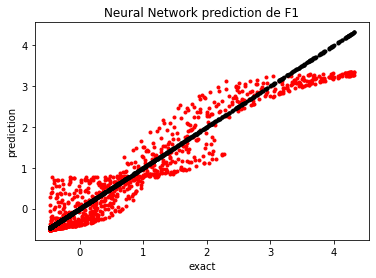

In [192]:
visualize1()

Model Performance
Correlation: 1.0000.
R2: 0.7652.


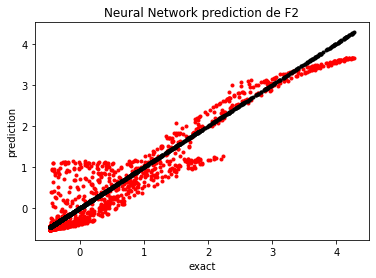

In [193]:
visualize2()

Model Performance
Correlation: 1.0000.
R2: 0.7652.


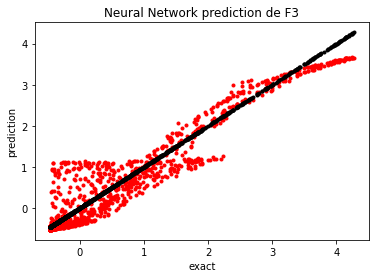

In [194]:
visualize3()

Model Performance
Correlation: 1.0000.
R2: 0.7652.


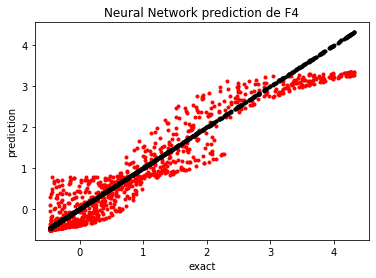

In [195]:
visualize4()

# Visualisation de la Loss-fonction

In [114]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 26208.